Defining Wumpus World Environment

In [ ]:
import numpy as np

class SimpleWumpusWorld:
    def __init__(self):
        self.rows  = 4
        self.cols  = 4
        self.start = (3, 0)
        self.gold  = (1, 2)
        self.pits  = [(0, 3), (2, 2), (0, 0)]
        self.wumpus = (1, 0)
        self.reset()

    def reset(self):
        self.agent_pos    = list(self.start)
        self.done         = False
        self.arrow_used   = False
        self.wumpus_alive = True
        self.rewards = np.full((self.rows, self.cols), -1)

        for pit in self.pits:
            self.rewards[pit] = -1000
        self.rewards[self.gold]   =  100
        self.rewards[self.wumpus] = -1000

        return self.agent_pos.copy()

    def step(self, action):
        x, y = self.agent_pos
        new_x, new_y = x, y
        reward = -1  # default step penalty

        if action == 0 and x > 0:        # up
            new_x -= 1
        elif action == 1 and x < 3:      # down
            new_x += 1
        elif action == 2 and y > 0:      # left
            new_y -= 1
        elif action == 3 and y < 3:      # right
            new_y += 1

        self.agent_pos = [new_x, new_y]
        cell = self.rewards[new_x, new_y]

        if cell == -1000:                # pit or wumpus
            reward = -1000
            self.done = True
        elif cell == 100:                # gold
            reward = 100
            self.done = True

        return self.agent_pos.copy(), reward, self.done

    def render(self):
        """Print the grid; agent (A) is shown in green (ANSI)."""
        grid = np.full((self.rows, self.cols), '.')
        for (i, j) in self.pits:
            grid[i, j] = 'P'
        if self.wumpus_alive:
            grid[self.wumpus] = 'W'
        grid[self.gold] = 'G'

        x, y = self.agent_pos
        grid[x, y] = '\033[92mA\033[0m'   # green-colored agent

        for row in grid:
            print(' '.join(row))


Q learning

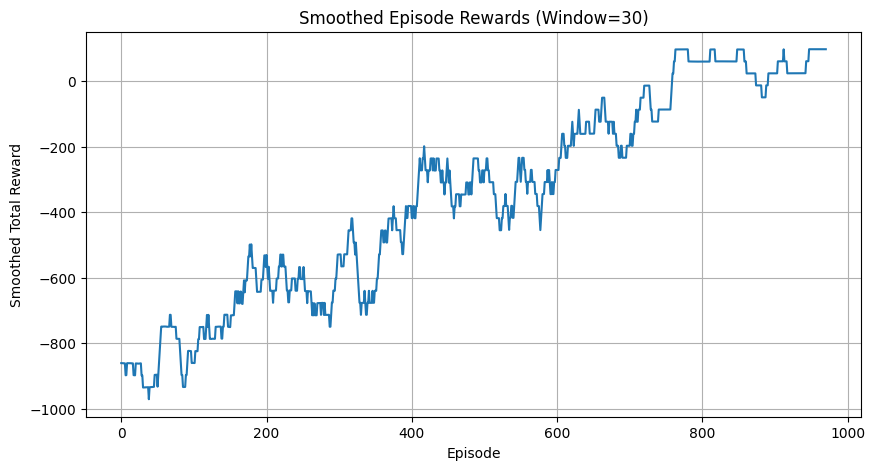

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
NUM_ACTIONS = 4
q_table = np.zeros((4, 4, NUM_ACTIONS))

# Hyperparameters
alpha = 0.1
gamma = 0.9
epsilon = 1.0
epsilon_min = 0.01
episodes = 1000
max_steps = 50

# Rewards tracker
episode_rewards = []

for ep in range(episodes):
    env = SimpleWumpusWorld()
    state = env.reset()
    total_reward = 0
    done = False
    steps = 0

    # Linear epsilon decay
    epsilon = max(epsilon_min, 1 - ep / episodes)

    while not done and steps < max_steps:
        x, y = state

        # ε-greedy action selection
        if np.random.rand() < epsilon:
            action = np.random.randint(NUM_ACTIONS)
        else:
            action = np.argmax(q_table[x, y])

        next_state, reward, done = env.step(action)
        nx, ny = next_state

        # Q-learning update rule
        q_table[x, y, action] = q_table[x, y, action] * (1 - alpha) + \
                                alpha * (reward + gamma * np.max(q_table[nx, ny]))

        state = next_state
        total_reward += reward
        steps += 1

    episode_rewards.append(total_reward)

# Plot smoothed reward
def moving_average(data, window=30):
    return np.convolve(data, np.ones(window)/window, mode='valid')

smoothed_rewards = moving_average(episode_rewards)

plt.figure(figsize=(10, 5))
plt.plot(smoothed_rewards)
plt.title("Smoothed Episode Rewards (Window=30)")
plt.xlabel("Episode")
plt.ylabel("Smoothed Total Reward")
plt.grid(True)
plt.show()


In [ ]:
def show_optimal_path(q_table):
    # Initialize environment
    env = SimpleWumpusWorld()
    state = env.reset()
    path = [state.copy()]
    done = False
    steps = 0
    max_steps = 20  # Prevent infinite loops

    # Follow the best action from Q-table until termination
    while not done and steps < max_steps:
        x, y = state

        # Choose the best action based on Q-table
        action = np.argmax(q_table[x, y])

        # Apply the action in the environment
        next_state, reward, done = env.step(action)

        # Add the new state to the path
        path.append(next_state.copy())

        # Update current state
        state = next_state
        steps += 1

    return path

# Display optimal path after training
optimal_path = show_optimal_path(q_table)
print("Optimal Path from Start to Goal (or Failure):")
for pos in optimal_path:
    print(pos)


Optimal Path from Start to Goal (or Failure):
[3, 0]
[3, 1]
[2, 1]
[1, 1]
[1, 2]


In [ ]:
import time  # for delay between steps

def show_optimal_path_visual(q_table, delay=0.5):
    # Initialize environment
    env = SimpleWumpusWorld()
    state = env.reset()
    path = [state.copy()]
    done = False
    steps = 0
    max_steps = 20  # To prevent infinite loops

    print("Starting Optimal Path Visualization...\n")

    while not done and steps < max_steps:
        # Render current environment
        env.render()
        print()  # blank line for readability
        time.sleep(delay)

        x, y = state
        action = np.argmax(q_table[x, y])
        next_state, reward, done = env.step(action)

        path.append(next_state.copy())
        state = next_state
        steps += 1

    # Final render
    env.render()
    print("\nFinal Position (Terminated)")
    return path

# Run the visualization
optimal_path = show_optimal_path_visual(q_table, delay=0.6)


Starting Optimal Path Visualization...

P . . P
W . G .
. . P .
 . . .

P . . P
W . G .
. . P .
.  . .

P . . P
W . G .
.  P .
. . . .

P . . P
W  G .
. . P .
. . . .

P . . P
W .  .
. . P .
. . . .

Final Position (Terminated)


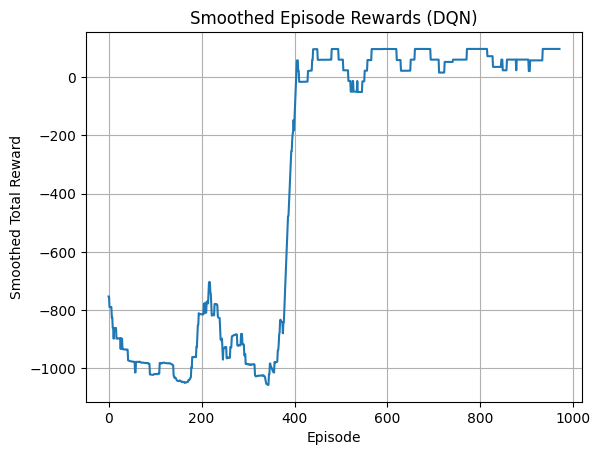

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt

# Define the DQN model
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.model(x)

# Function to convert (x,y) position to one-hot 16D vector
def encode_state(pos, grid_size=4):
    state_vec = np.zeros(grid_size * grid_size)
    idx = pos[0] * grid_size + pos[1]
    state_vec[idx] = 1
    return torch.FloatTensor(state_vec).to(device)

# Hyperparameters
episodes = 1000
gamma = 0.95
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
lr = 0.001
batch_size = 64
memory = deque(maxlen=2000)

# Environment and model setup
env = SimpleWumpusWorld()
input_dim = 16     # 4x4 grid flattened
output_dim = 4     # up, down, left, right

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
policy_net = DQN(input_dim, output_dim).to(device)
optimizer = optim.Adam(policy_net.parameters(), lr=lr)
loss_fn = nn.MSELoss()

reward_history = []

# Training loop
for episode in range(episodes):
    state_raw = env.reset()
    state = encode_state(state_raw)
    total_reward = 0
    done = False

    while not done:
        # Epsilon-greedy strategy
        if np.random.rand() < epsilon:
            action = np.random.randint(output_dim)
        else:
            with torch.no_grad():
                action = policy_net(state).argmax().item()

        next_state_raw, reward, done = env.step(action)
        next_state = encode_state(next_state_raw)

        # Store transition in memory
        memory.append((state, action, reward, next_state, done))
        state = next_state
        total_reward += reward

        # Learn from memory
        if len(memory) >= batch_size:
            batch = random.sample(memory, batch_size)
            states, actions, rewards, next_states, dones = zip(*batch)

            states = torch.stack(states)
            next_states = torch.stack(next_states)
            actions = torch.LongTensor(actions).unsqueeze(1).to(device)
            rewards = torch.FloatTensor(rewards).to(device)
            dones = torch.BoolTensor(dones).to(device)

            q_values = policy_net(states).gather(1, actions).squeeze()
            with torch.no_grad():
                q_next = policy_net(next_states).max(1)[0]
                q_target = rewards + gamma * q_next * (~dones)

            loss = loss_fn(q_values, q_target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Decay epsilon
    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    reward_history.append(total_reward)

# Plot smoothed cumulative reward
window = 30
smoothed = np.convolve(reward_history, np.ones(window)/window, mode='valid')
plt.plot(smoothed)
plt.title("Smoothed Episode Rewards (DQN)")
plt.xlabel("Episode")
plt.ylabel("Smoothed Total Reward")
plt.grid(True)
plt.show()


In [ ]:
# Calculate average total reward after 1000 episodes
avg_reward_qlearning = sum(episode_rewards) / len(episode_rewards)
avg_reward_dqn = sum(reward_history) / len(reward_history)

print(f"Average Reward (Q-learning): {avg_reward_qlearning:.2f}")
print(f"Average Reward (DQN): {avg_reward_dqn:.2f}")


Average Reward (Q-learning): -356.58
Average Reward (DQN): -343.40


In [ ]:
import numpy as np

# Constants
NUM_ACTIONS = 4
q_table = np.zeros((4, 4, NUM_ACTIONS))

# Hyperparameters
alpha = 0.1
gamma = 0.9
epsilon = 1.0
epsilon_min = 0.01
episodes = 1000
max_steps = 50

# Tracking successful episodes
success_episodes = []

# Dummy environment interface
class SimpleWumpusWorld:
    def __init__(self):
        self.rows = 4
        self.cols = 4
        self.start = (3, 0)
        self.gold = (1, 2)
        self.pits = [(0, 3), (2, 2), (0, 0)]
        self.wumpus = (1, 0)
        self.reset()

    def reset(self):
        self.agent_pos = list(self.start)
        self.done = False
        self.rewards = np.full((self.rows, self.cols), -1)

        for pit in self.pits:
            self.rewards[pit] = -1000
        self.rewards[self.gold] = 100
        self.rewards[self.wumpus] = -1000

        return self.agent_pos.copy()

    def step(self, action):
        x, y = self.agent_pos
        new_x, new_y = x, y
        reward = -1

        if action == 0 and x > 0:       # up
            new_x -= 1
        elif action == 1 and x < 3:     # down
            new_x += 1
        elif action == 2 and y > 0:     # left
            new_y -= 1
        elif action == 3 and y < 3:     # right
            new_y += 1

        self.agent_pos = [new_x, new_y]
        cell = self.rewards[new_x, new_y]

        if cell == -1000:
            reward = -1000
            self.done = True
        elif cell == 100:
            reward = 100
            self.done = True

        return self.agent_pos.copy(), reward, self.done

# Loop through episodes and track successful completions
consecutive_successes = 0
first_stable_success = None

for ep in range(episodes):
    env = SimpleWumpusWorld()
    state = env.reset()
    total_reward = 0
    done = False
    steps = 0
    success = False

    epsilon = max(epsilon_min, 1 - ep / episodes)

    while not done and steps < max_steps:
        x, y = state

        if np.random.rand() < epsilon:
            action = np.random.randint(NUM_ACTIONS)
        else:
            action = np.argmax(q_table[x, y])

        next_state, reward, done = env.step(action)
        nx, ny = next_state

        q_table[x, y, action] = q_table[x, y, action] * (1 - alpha) + \
                                alpha * (reward + gamma * np.max(q_table[nx, ny]))

        state = next_state
        total_reward += reward
        steps += 1

        if reward == 100:
            success = True
        elif reward == -1000:
            success = False
            break

    if success:
        consecutive_successes += 1
        if consecutive_successes >= 5 and first_stable_success is None:
            first_stable_success = ep - 4
    else:
        consecutive_successes = 0

first_stable_success
# Final output with description
if first_stable_success is not None:
    print(f"EPISODES TOOK TO CONSISTENTLY REACH THE GOLD WITHOUT FAILURE = {first_stable_success}")
else:
    print("Agent did not achieve 5 consecutive successful episodes within 1000 episodes.")


EPISODES TOOK TO CONSISTENTLY REACH THE GOLD WITHOUT FAILURE = 428
